# AMMA Post Processing

**Converting Pianorolls to MIDI Files**

*by Matthew Avallone, Anish Malhotra*

# Imports

In [0]:
import numpy as np
import pretty_midi
import os

In [8]:
!pip install pypianoroll

In [0]:
import pypianoroll
from pypianoroll import Track, Multitrack

In [0]:
num_classes = 7
note_shift = 24
num_of_notes = 83

In [11]:
! wget https://drive.google.com/open?id=1OsOU83Dq8b4Nwyy6UP9BPGSfFzRs0cBt

--2019-06-02 16:18:09--  https://drive.google.com/open?id=1OsOU83Dq8b4Nwyy6UP9BPGSfFzRs0cBt
Resolving drive.google.com (drive.google.com)... 74.125.20.101, 74.125.20.113, 74.125.20.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.google.com/open?id%3D1OsOU83Dq8b4Nwyy6UP9BPGSfFzRs0cBt&followup=https://drive.google.com/open?id%3D1OsOU83Dq8b4Nwyy6UP9BPGSfFzRs0cBt [following]
--2019-06-02 16:18:09--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.google.com/open?id%3D1OsOU83Dq8b4Nwyy6UP9BPGSfFzRs0cBt&followup=https://drive.google.com/open?id%3D1OsOU83Dq8b4Nwyy6UP9BPGSfFzRs0cBt
Resolving accounts.google.com (accounts.google.com)... 74.125.195.84, 2607:f8b0:400e:c09::54
Connecting to accounts.google.com (accounts.google.com)|74.125.195.84|:443... connect

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from google.colab import drive
from oauth2client.client import GoogleCredentials

In [13]:
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Set Instrument Class

In [0]:
CLASS = 'Strings'

# **Load Models**

In [15]:
from keras.models import load_model

Using TensorFlow backend.


In [0]:
model_folder = '/content/gdrive/My Drive/Senior Design Project/Saved Models/' + CLASS + '/'
os.chdir(model_folder)

In [17]:
autoencoder = load_model(model_folder + CLASS.lower() + '_model.h5')
encoder = load_model(model_folder + CLASS.lower() + '_encoder.h5')
decoder = load_model(model_folder + CLASS.lower() + '_decoder.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# **Load Melody**

In [0]:
song_folder = '/content/gdrive/My Drive/Senior Design Project/MIDI Test Songs/'
os.chdir(song_folder)

In [0]:
file = 'Anish Demo 1 (simple).mid'

song = pypianoroll.parse(song_folder + file)

Extract Melody Track

In [0]:
mel = np.empty(song.tracks[1].pianoroll.shape)
melody_track = Track()

for track in song.tracks:
    if('Melody' in track.name):
        mel = track.pianoroll
        melody_track = track
        break

Truncating Pianoroll to range of 83 Notes

In [0]:
melody = mel[:, note_shift : note_shift+num_of_notes]

In [23]:
print(melody.shape)

(384, 83)


Turn it into phrases

In [0]:
tpqn = 96 # Ticks Per Quarter Note resolution. Varies with MIDI file, currently using same resolution
num_measures = 0.25 # number of bars/measures
phrase_length =int(num_measures*4*tpqn) # in ticks

In [0]:
X_phrase = []
empty_indices = []
non_empty_indices = dict()

phrase_end = phrase_length # initialize the end of a phrase to be 4 bars from first tick

for phrase_start in range(0,len(melody) - phrase_length + 1, phrase_length):
    # print(phrase_start, phrase_end)
    phrase = melody[phrase_start:phrase_end] # grab a phrase

    if(np.any(np.count_nonzero(phrase, axis=1)) > 0): # if any string bar is not empty
        X_phrase.append(phrase) # grab the input phrase at same song/indices
        non_empty_indices[phrase_start] = phrase
    else:
        empty_indices.append(phrase_start)

        # print(phrase)
    phrase_end += phrase_length

In [0]:
print(empty_indices)

[]


# **Generate Accompaniment**

In [0]:
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)

    # collect predictions
    output = list()
    for t in range(n_steps):
        
        # predict next note
        yhat, h, c = infdec.predict([target_seq] + state)

        # store prediction
        output.append(yhat[0,0,:])
       
        # update state
        state = [h, c]
        
        # update target sequence
        target_seq = yhat
        
    return (np.array(output)).reshape(n_steps,cardinality)

In [0]:
print(len(X_phrase))

4


In [0]:
test_phrase = np.empty((1, phrase_length, num_of_notes))
ypred = np.empty(shape=(len(X_phrase), phrase_length, num_of_notes))

for i in range(0, len(X_phrase)):
    test_phrase[0] = X_phrase[i]
    ypred[i] = predict_sequence(encoder, decoder, test_phrase, phrase_length, num_of_notes)

Concatenateing predicted phrases into single pianroll (num_ticks x 83)

In [0]:
# total_ticks = phrase_length*len(ypred)
pred_pianoroll = np.zeros((phrase_length, num_of_notes))
phrase_position = phrase_length
j = 0
for i in range(0, melody_track.pianoroll.shape[0]):
    if(phrase_position in empty_indices):
        pred_pianoroll = np.vstack((pred_pianoroll, np.zeros((phrase_length, num_of_notes))))
    elif(phrase_position in non_empty_indices.keys()):
        pred_pianoroll = np.vstack((pred_pianoroll, ypred[j]))
        j += 1
    
    phrase_position += phrase_length

In [0]:
print(pred_pianoroll.shape)
# print(pred_pianoroll[1536])

(384, 83)


# Converting Output to MIDI Format

##Formatting the Output into Pianorolls

Reconstructing Pianoroll Shape (num_ticks x 128)

In [0]:
# This is just for a single pianoroll

num_ticks = pred_pianoroll.shape[0]

beginning_pad = np.zeros((num_ticks, note_shift)) # adding zeros to beginning notes
ending_pad = np.zeros((num_ticks, 128-num_of_notes-note_shift)) # adding zeros to ending notes

output_pianoroll = np.hstack((beginning_pad, pred_pianoroll))
output_pianoroll = np.hstack((output_pianoroll, ending_pad))

print(output_pianoroll.shape)

(384, 128)


## Creating the Multitrack File

In [0]:
from matplotlib import pyplot as plt

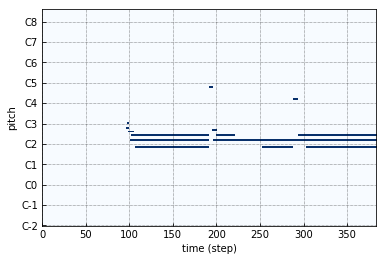

In [0]:
test_accompaniment = Track(pianoroll=output_pianoroll, program=48, is_drum=False,
              name=CLASS)

# Demo 1 (simple)
# binarized_threshold = 0.098 # percussion
# binarized_threshold = 0.068 # bass
# binarized_threshold = 0.15 # winds
# binarized_threshold = 0.15 # strings

# Demo 2 (complex)
binarized_threshold = 0.1 # strings
# binarized_threshold = 0.25 # winds
# binarized_threshold = 0.0643 # bass
# binarized_threshold = 0.064 # chords
# binarized_threshold = 0.1 # percussion

test_accompaniment.binarize(threshold=binarized_threshold) # format into 1 and 0

test_accompaniment.pad(melody_track.pianoroll.shape[0]-pred_pianoroll.shape[0])

# Plot the piano-roll
fig, ax = test_accompaniment.plot()
plt.show()

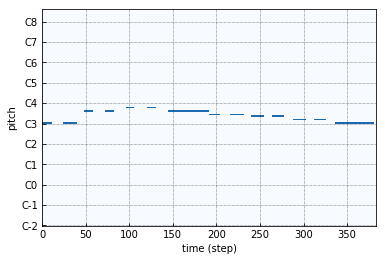

In [26]:
# Plot the melody piano-roll
fig, ax = melody_track.plot()
plt.show()

Melody


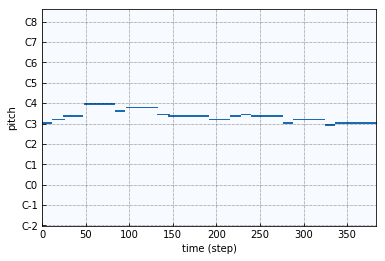

Steinway Grand Piano


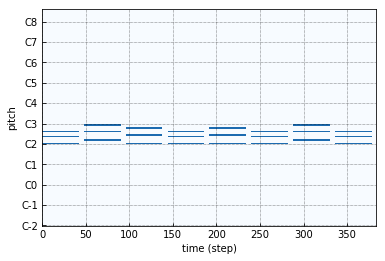

Fingerstyle Bass


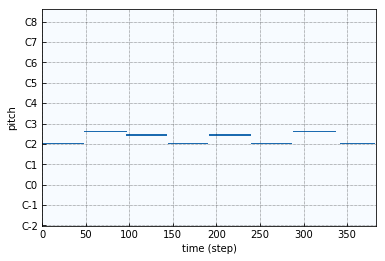

Drummer


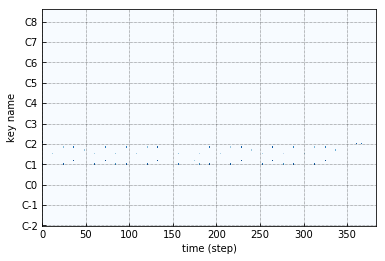

In [0]:
for track in song.tracks:
    print(track.name)
    fig, ax = track.plot()
    plt.show()

Preparing the Multitrack object

In [0]:
num_ticks = melody_track.pianoroll.shape[0]

downbeats = np.zeros(num_ticks, dtype=bool)
for b in range(0, num_ticks):
    if(b % 24 == 0):
        downbeats[b] = True

In [0]:
# song.append_track(test_accompaniment)

new_song = Multitrack(tracks=[melody_track], beat_resolution=24, downbeat=downbeats, name='new_song')
new_song.append_track(test_accompaniment)

## **Saving the Multitrack As MIDI**

In [0]:
import time
output_dir = '/content/gdrive/My Drive/Senior Design Project/MIDI Output Data/' + CLASS + '/'
timestr = time.strftime("%Y%m%d-%H%M%S")

os.chdir(output_dir)

In [0]:
# pypianoroll.write(new_song, output_dir + 'test_output-' + CLASS.lower() + '-' str(binarize_threshold) + '-' + timestr + '-' + '.mid')

In [0]:
accompaniment = Multitrack(tracks=[test_accompaniment], beat_resolution=24, downbeat=downbeats, name='accompaniment')

dir = '/content/gdrive/My Drive/Senior Design Project/MIDI Output Data/'

pypianoroll.write(accompaniment, dir + CLASS.lower() + '_accompaniment -' + str(binarized_threshold) + '-' + timestr + '-' + '.mid')

In [0]:
mel_track = Multitrack(tracks=[melody_track], beat_resolution=24, downbeat=downbeats, name='melody')

# pypianoroll.write(mel_track, dir + 'melody_accompaniment' + '-' + timestr + '-' + '.mid')

# **Reviewing Generated Song**

Anish Demo 1

In [0]:
output_dir = '/content/gdrive/My Drive/Senior Design Project/MIDI Output Data/Tests/'
os.chdir(output_dir)

In [0]:
amma_demo1 = pypianoroll.parse(output_dir + 'amma-demo1-42519.mid')

Melody


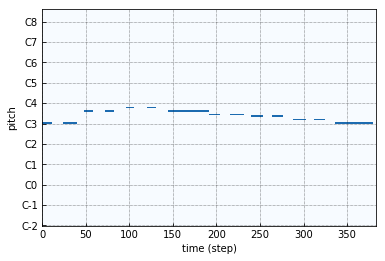

Bass


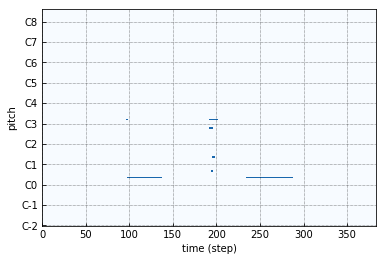

Chords


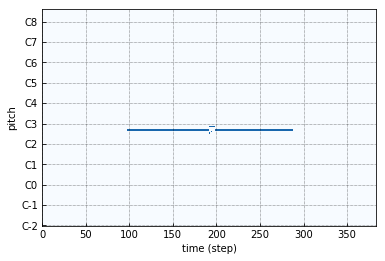

Drums


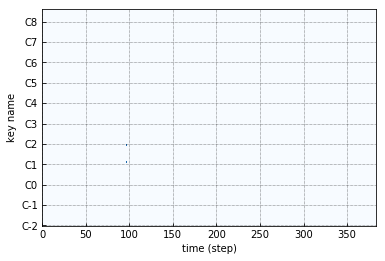

Strings


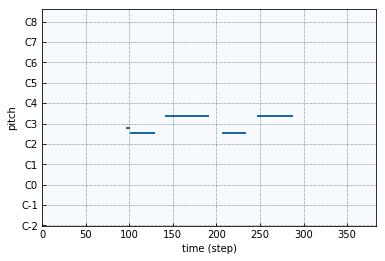

Winds


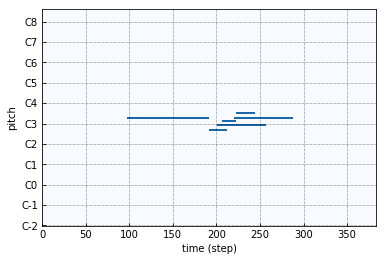

In [0]:
for track in amma_demo1.tracks:
    print(track.name)
    fig, ax = track.plot()
    plt.show()

Anish Demo 2

In [0]:
amma_demo2 = pypianoroll.parse(output_dir + 'amma-demo2-42519.mid')

Melody


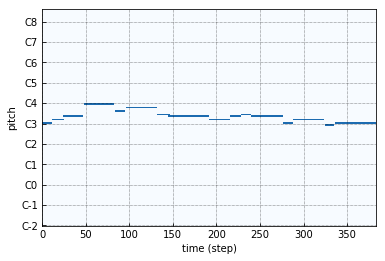

Bass


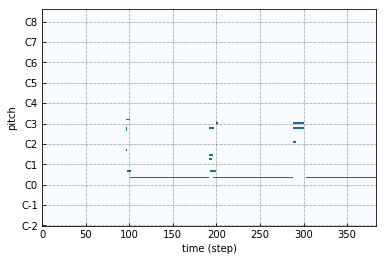

Chords


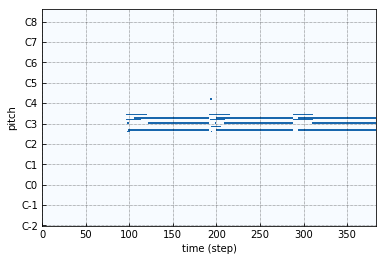

Percussion


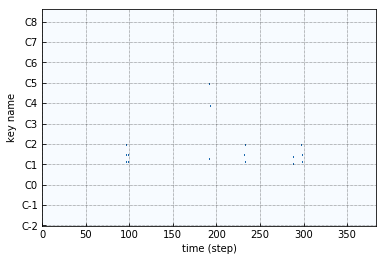

Strings


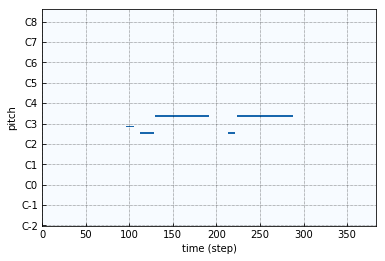

Winds


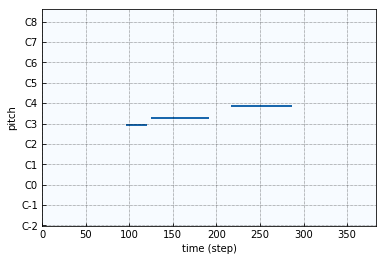

In [0]:
for track in amma_demo2.tracks:
    print(track.name)
    fig, ax = track.plot()
    plt.show()